In [1]:
from PIL import Image, ImageStat
from PIL.ImageDraw import ImageDraw

import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F

from random import randint
from math import pi

import os
from os import path

from fastai import vision
from fastai.vision import ImageList, FloatList, cnn_learner, pil2tensor, open_image
from fastai.callbacks import EarlyStoppingCallback, ReduceLROnPlateauCallback, CSVLogger
from fastai.train import ShowGraph, Learner
from fastai.metrics import mean_absolute_error, mean_squared_error
from torchvision import models
from torch import nn
import numpy as np

from functools import partial

## Local Imports ##
from models import helpers as model_helpers, models as custom_models
from datasets import helpers as dataset_helpers, datasets as custom_datasets

In [2]:
W, H = (512, 512)
BS = 128
DT_ROOT = 'data'
POLYGON_COUNT_DIR = 'polygon_data_counts'
POLYGON_PERCENTAGE_DIR = 'polygon_data_percentage'

counts_options = {
        "train_dir": path.join(DT_ROOT, POLYGON_COUNT_DIR, 'train', 'images'),
        "test_dir": path.join(DT_ROOT, POLYGON_COUNT_DIR, 'test', 'images'),
        "df_train": pd.read_csv(
                path.join(DT_ROOT, POLYGON_COUNT_DIR, 'train', 'data.csv'),
                index_col=0
            ),
        "df_test": pd.read_csv(
                path.join(DT_ROOT, POLYGON_COUNT_DIR, 'train', 'data.csv'),
                index_col=0
            ),
        "bs": BS,
        "transform_args": {"size": (W, H)},
        "device": "cuda"
}

percentage_options = {
    "train_dir": path.join(DT_ROOT, POLYGON_PERCENTAGE_DIR, 'train', 'images'),
    "test_dir": path.join(DT_ROOT, POLYGON_PERCENTAGE_DIR, 'test', 'images'),
    "df_train": pd.read_csv(
            path.join(DT_ROOT, POLYGON_PERCENTAGE_DIR, 'train', 'data.csv'),
            index_col=0
        ),
    "df_test": pd.read_csv(
            path.join(DT_ROOT, POLYGON_PERCENTAGE_DIR, 'train', 'data.csv'),
            index_col=0
        ),
    "bs": BS,
    "transform_args": {"size": (W, H)},
    "device": "cuda"
}


dataset_generators = [
    lambda: custom_datasets.get_dataset(**counts_options),
    lambda: custom_datasets.get_dataset(**percentage_options)
]


metrics = [
    mean_squared_error,
    mean_absolute_error
]

EARLY_STOP_PATIENCE = 1
REDUCE_ON_PLATEAU_PATIENCE = 2 
MAX_EPOCHS = 1

In [3]:
models_to_test = custom_models.get_models()
loss = nn.L1Loss()
loss_fn = lambda x,y: loss(x.view(-1), y)


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,843066624.000000,824771904.000000,824771840.000000,16316.451172,00:23


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.000682,0.000058,0.000058,0.004699,00:22


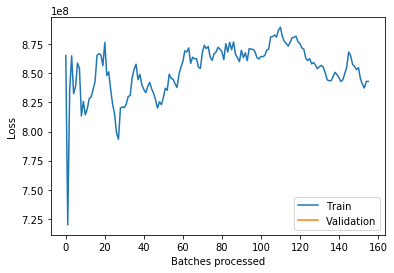

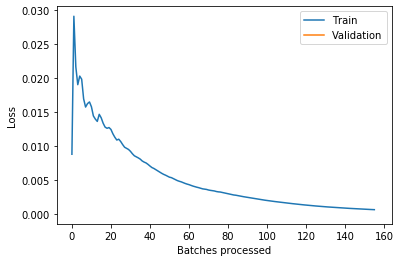

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

for dataset in dataset_generators:
    bunch = dataset()
    learn = Learner(
        model=nn.Sequential(Flatten(), nn.Linear(W * H, 1)),
        data=bunch,
        path=path.abspath(path.join(bunch.path, '..', '..', 'results', 'mlp')),
        callback_fns=[
            partial(EarlyStoppingCallback, patience=EARLY_STOP_PATIENCE), 
            partial(ReduceLROnPlateauCallback, patience=REDUCE_ON_PLATEAU_PATIENCE),
            partial(CSVLogger, filename=f"history_mlp")
        ],
        metrics=metrics,
        silent=False
    )
    learn.fit(MAX_EPOCHS)
    model_helpers.save_stats(learn, 'mlp')
    learn.save("mlp")

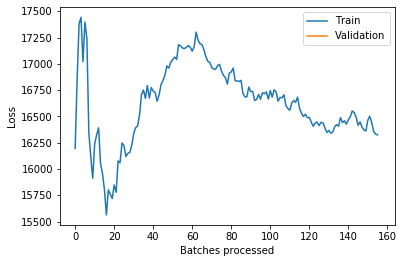

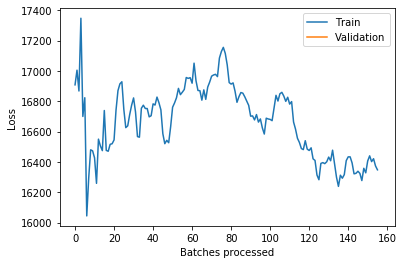

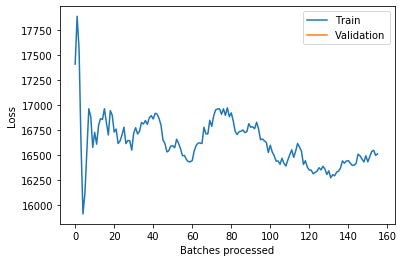

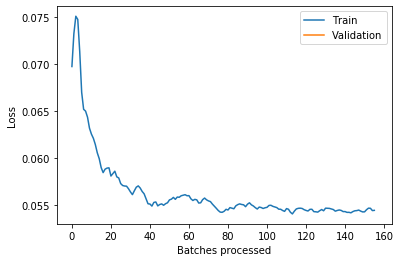

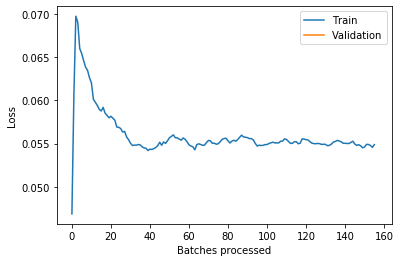

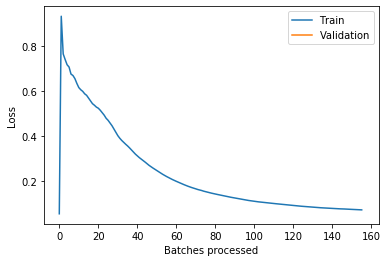

In [5]:
for dataset in dataset_generators:
    bunch = dataset()
    for model in models_to_test:
        learn = cnn_learner(
            data=bunch,
            path=path.abspath(path.join(bunch.path, '..', '..', 'results', model['name'])),
            base_arch=lambda t: model["model"],
            cut=lambda x: x,
            loss_func=loss_fn,
            callback_fns=[
                partial(EarlyStoppingCallback, patience=EARLY_STOP_PATIENCE), 
                partial(ReduceLROnPlateauCallback, patience=REDUCE_ON_PLATEAU_PATIENCE),
                partial(CSVLogger, filename=f"history_{model['name']}")
            ],
            metrics=metrics,
            silent=True
        )
        learn.fit(MAX_EPOCHS)
        model_helpers.save_stats(learn, model["name"])
        learn.save(model["name"])

In [6]:
DT_ROOT_DIRS = map(lambda p: path.join(DT_ROOT, p, 'results'),[POLYGON_COUNT_DIR, POLYGON_PERCENTAGE_DIR])
for root_dir in :
    model_helpers.summarize_results([*models_to_test, {"name":"mlp"}], root_dir)

SyntaxError: invalid syntax (<ipython-input-6-90fcf97a3081>, line 2)